In [5]:
import sys
sys.path.insert(0, '../')

import numpy as np
import matplotlib.pyplot as plt
from ssfp import gs_recon, bssfp as ssfp
from gasp import gasp

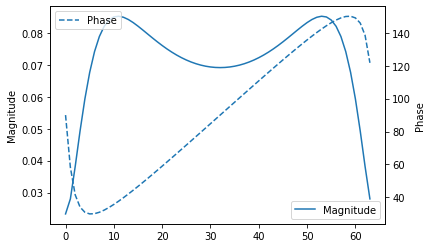

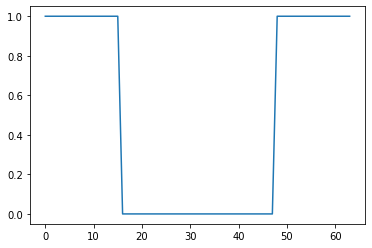

In [16]:
''' Taken from single_tr_sim.py'''

'''Example of how GASP works using simulated data using single TR.

I'm not completely sure that this is working.  Might not be that
interesting anyway because it only uses one TR and thus must get all
of its spectral information from many phase-cycles.
'''


# Experiment parameters
TR = 5e-3
alpha = np.deg2rad(10)
npcs = 64
pcs = np.linspace(0, 2*np.pi, npcs, endpoint=False)
# pcs = 0

# Tissue parameters
T1 = 1.2
T2 = .035
M0 = 1
df = 0
# df = np.linspace(-1/TR, 1/TR, npcs, endpoint=False)
phi_rf = np.deg2rad(0)

# Simulate acquisition of phase-cycles for a single voxel
I = ssfp(T1, T2, TR, alpha, df, pcs, M0, phi_rf=phi_rf)

# Take a gander
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.abs(I), label='Magnitude')
ax2.plot(np.rad2deg(np.angle(I)), '--', label='Phase')
ax1.legend()
ax1.set_ylabel('Magnitude')
ax2.legend()
ax2.set_ylabel('Phase')
plt.show()

# # Make a box
box = np.zeros(npcs)
box[int(npcs/4):-int(npcs/4)] = 1
box = np.roll(box, int(box.size/2))
plt.plot(box)
plt.show()


In [12]:
I.shape

(64,)

In [ ]:
# Now try for a phantom
N = 128
T1 = np.zeros((N, N))
T2 = np.zeros((N, N))
offres = np.zeros((N, N))
alpha = np.ones((N, N))*np.deg2rad(30)
M0 = np.zeros((N, N))

# Make a simple off-resonance map, linear gradient
min_df, max_df = -1/TR, 1/TR
fx = np.linspace(min_df, max_df, N)
fy = np.zeros(N)
offres, _ = np.meshgrid(fx, fy)

# Next set up the desired values across the phantom.  This
# phantom will be fat on top and water on bottom.
hi = np.ceil(.9*N).astype(int)
mid = int(N/2)
lo = np.floor(.1*N).astype(int)

# At 3 T fat has a T1 of 300 ms and a T2 of 85 ms. synovial fluid
# 4813 T1, 325 T2
mask0 = np.zeros((N, N)).astype(bool)
mask0[lo:mid, lo:hi] = True
T1[mask0] = .300
T2[mask0] = .085
M0[mask0] = 1

# At 3 T water has a T1 of 3000 ms and a T2 of 160 ms. Cartilage
# 1568 T1, 32 T2
mask1 = np.zeros((N, N)).astype(bool)
mask1[mid+1:hi, lo:hi] = True
T1[mask1] = 1.200
T2[mask1] = .030
M0[mask1] = 1

# Get effective mask:
mask = mask0 + mask1

# SSFP sim
I = ssfp(T1, T2, TR, alpha, offres, pcs, M0, phi_rf=0)

# plt.imshow(np.abs(I[0, ...]))
# plt.show()

# Make a box
box = np.zeros(npcs)
left_zeros = 30
right_zeros = 30
slide = 0
box[left_zeros:-right_zeros] = 1
box = np.roll(box, int(slide))
plt.plot(box)
plt.show()

# Do the thing!
I0 = gasp(I, box, C_dim=(int(N/2), int(N/2)))
print(I.shape, I0.shape)

# Find the 0, 90, 180, 270 phase-cycles to do GS recon on
idx = [ii for ii, val in enumerate(np.rad2deg(
    pcs).astype(int)) if val in [0, 90, 180, 270]]

# Show me da apples!
plt.imshow(np.abs(gs_recon(I[idx, ...], pc_axis=0)))
plt.show()
plt.imshow(np.abs(I0))
plt.show()

# Take a slice through the water phantom to compare with desired
# spectral profile
mid = int(I0.shape[0]/4)
plt.plot(np.abs(I0[mid, :]))
p = int((I0.shape[1]-box.size)/2)
plt.plot(np.concatenate((np.zeros(p), box, np.zeros(p))), '--')
plt.show()
